In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import networkx as nx
import talib as ta
from tqdm import tqdm
data = pd.read_csv('./data.csv',header = 0)
close = data.pivot_table(index = 'date', columns = 'ticker', values = 'last')
vol = data.pivot_table(index = 'date', columns = 'ticker', values = 'volume')
time_length = close.shape[0]

### Factor Construct

$plrc4:close=a+\beta t,t=0,1,2,...,n, (a,\beta)=(X^{T}X)^{-1}X^{T}Y$

$\text{graph feature}:\text{Features from graph theory such as the degree,eigenvalue centrality,betweeness}$

$\text{vc_corr}:corr(rank(close),rank(volume))$

In [282]:
rtn = close.pct_change(1).dropna(axis=0, how = 'all')
trading_date = close.index.tolist()

def build_edge_df(cor,thesh):
    '''Construct the market graph edges and nodes'''
    pos_edge = (cor>=thesh)*1
    new_ind = np.arange(0,len(asset))
    ind_dict = dict(zip(new_ind,pos_edge.index.tolist()))
    pos_edge.index = new_ind
    pos_edge.columns = new_ind
    neg_edge.index = new_ind
    neg_edge.columns = new_ind
    multi_edge = pd.MultiIndex.from_product([pos_edge.index.tolist(),pos_edge.index.tolist()])
    edge = np.array(multi_edge).reshape(len(asset),-1)*pos_edge.values
    edge_list = edge.tolist()
    s = pd.Series(edge.reshape(-1,))
    ind = [list(i) for i in s[s!=()].tolist()]
    ind_df = pd.DataFrame(np.array(ind),columns = ['source', 'target'])
    ind_df = ind_df[ind_df['source'] != ind_df['target']]
    return ind_df,ind_dict

def graph_feat(rtn, length = 20, thesh = 0.3):
    '''cost about 20min to calculate'''
    pos_corr_feat = pd.DataFrame()
    neg_corr_feat = pd.DataFrame()
    eig_centra = pd.DataFrame(index = np.arange(len(asset))).T
    deg_centra = pd.DataFrame(index = np.arange(len(asset))).T
    bet_centra = pd.DataFrame(index = np.arange(len(asset))).T
    for i in tqdm(range(rtn.shape[0] - length)):
        cut = rtn.iloc[i:i+length,:]
        cor = cut.corr()
        current_date = trading_date[i+length-1]
        cor_pos = cor[cor>=thesh].count().to_frame(name =current_date).T
        cor_neg = cor[cor<=-thesh].count().to_frame(name =current_date).T
        pos_corr_feat = pd.concat([pos_corr_feat,cor_pos],axis = 0)
        neg_corr_feat = pd.concat([neg_corr_feat,cor_neg],axis = 0)
        ind_df,ind_dict = build_edge_df(cor,thesh)
        G=nx.from_pandas_edgelist(ind_df.astype(int),source='source',target='target')
        nx_feat1 = pd.DataFrame(nx.degree_centrality(G),index = [current_date])
        nx_feat2 = pd.DataFrame(nx.eigenvector_centrality(G),index = [current_date])
        nx_feat3 = pd.DataFrame(nx.betweenness_centrality(G),index = [current_date])
        eig_centra = pd.concat([eig_centra,nx_feat2],axis=0)
        deg_centra = pd.concat([deg_centra,nx_feat1],axis=0)
        bet_centra = pd.concat([bet_centra,nx_feat3],axis=0)
    return pos_corr_feat,neg_corr_feat,eig_centra,deg_centra,bet_centra

def time_trend(data, length = 10):
    plrc4 = pd.DataFrame()
    for i in tqdm(range(time_length-length)):
        part = close.iloc[i:i+length,:].values
        X = sm.add_constant(np.arange(length))
        parm = np.linalg.inv(X.T.dot(X)).dot(X.T)[-1].dot(part).reshape(-1,1) # (X.T*X)^(-1)*X.T*Y
        parm_df = pd.DataFrame(parm, index = close.columns.tolist(),columns = [trading_date[i+length-1]]).T
        plrc4 = pd.concat([plrc4,parm_df],axis=0)
    return plrc4

def vc_corr(close,volume, length = 20):
    vc_cor = pd.DataFrame()
    for i in tqdm(range(close.shape[0] - length)):
        cp = close.iloc[i:i+20,:].rank(axis = 0).T
        vol_c = vol.iloc[i:i+20,:].rank(axis = 0).T
        df = pd.concat([vol_c,cp],axis = 0)
        n = int(vol_c.shape[0])
        fct = pd.DataFrame(np.diagonal(np.corrcoef(df)[:n,n:]),
                           index = vol.columns.tolist(), 
                           columns = [trading_date[i+length-1]]).T
        vc_cor = pd.concat([vc_cor, fct], axis=0)
    return vc_cor

def get_talib_feature(close):
    macd = close.apply(lambda x:ta.MACD(x)[1]).dropna(axis=0,how='all')
    apo =  close.apply(lambda x:ta.APO(x)).dropna(axis=0,how='all')
    roc = close.apply(lambda x:ta.ROC(x,20)).dropna(axis=0, how = 'all')
    ema = close.apply(lambda x:ta.EMA(x,20)).dropna(axis=0, how = 'all')
    linear = close.apply(lambda x:ta.LINEARREG(x,20)).dropna(axis=0, how = 'all')
    tsf = close.apply(lambda x:ta.TSF(x,20)).dropna(axis=0, how = 'all')
    bband = close.apply(lambda x:ta.BBANDS(x)[1]).dropna(axis=0, how = 'all')
    cmo = close.apply(lambda x:ta.CMO(x,20)).dropna(axis=0, how = 'all')
    return macd,roc,apo,ema,linear,tsf,bband,cmo

In [7]:
corr1,corr2,eig_feat,deg_feat,bet_feat = graph_feat(rtn)
macd,roc,apo,ema,linear,tsf,bband,cmo = get_talib_feature(close)
reg = time_trend(close)
vcor = vc_corr(close, vol,length = 20)
eig_feat.columns = corr1.columns.tolist()
deg_feat.columns = corr1.columns.tolist()
bet_feat.columns = corr1.columns.tolist()

In [394]:
vol_corr1,vol_corr2,vol_eig_feat,vol_deg_feat,vol_bet_feat = graph_feat(np.log(vol+1))
vol_eig_feat.columns = vol_corr1.columns.tolist()
vol_deg_feat.columns = vol_corr1.columns.tolist()
vol_bet_feat.columns = vol_corr1.columns.tolist()

100%|██████████████████████████████████████████████████████████████████████████████| 1985/1985 [29:30<00:00,  1.12it/s]


### Factor Analysis Frame(With reference to Alphalens)

In [362]:
def MultiIndexSeries(factor, col_name):
    '''Muitl-Index Series构建函数
    factor:index:date,columns:asset的Series
    '''
    date,ind = factor.index.tolist(),factor.columns.tolist()
    Muid = pd.MultiIndex.from_product([date,ind],names = ['date', 'asset'])
    M = pd.Series(factor.values.reshape(1,-1)[0],index = Muid)
    return M.to_frame(name = col_name)

def compute_forward_return(factor, price, periods=(1,5,10), filter_lmt = False):
    '''
    :param factor: MultiIndex
    :param price: price data
    :param periods: N-th yield,tuple or list
    :param filter_lmt: filter Up and Down Stocks
    :return:
    '''
    factor_date = factor.index.levels[0]
    price = price.filter(items=factor.index.levels[1])
    if len(factor_date) <= max(periods):
        raise Exception('Input length should be larger than maximum of period')
    rawdata_dict = {}
    for period in sorted(periods):
        fwdret =price.pct_change(period)
        key_name = str(period)+'D'
        if all([filter_lmt == True, period == 1]):
            mask = abs(fwdret) >= 0.10
            fwdret[mask] = np.nan
        fwdret = fwdret.shift(-period).reindex(factor_date)
        rawdata_dict[key_name] = np.concatenate(fwdret.values)
    df = pd.DataFrame.from_dict(rawdata_dict)
    mid = pd.MultiIndex.from_product([factor_date, price.columns], names = ['date', 'asset'])
    df.set_index(mid, inplace=True)
    return df

def quantile_rank_IC(merge_data, period_name, out_df = True):
    grouper = [
        'factor_quantile',merge_data.index.get_level_values('date')
    ]
    rank_ic_df = merge_data.groupby(grouper).apply(
        lambda x:stats.spearmanr(x[period_name], x['factor'])[0]
    )
    if out_df:
        rank_ic_df = rank_ic_df.to_frame(name = 'rank_ic').pivot_table(
            values = 'rank_ic', index = 'date',columns='factor_quantile'
        )
        return rank_ic_df
    else:
        return rank_ic_df
def factor_quantile(factor_data, quantiles, neg_pos = False):
    '''
    :param factor_data: 因子数据
    :param quantiles: 分组
    :param neg_pos: 是否以0作为划分
    :return:
    '''
    def calc_qcut(x, _quantiles,neg_pos = False):
        if neg_pos == False:
            return pd.qcut(x, _quantiles, labels=False, duplicates='drop')+1
        if neg_pos == True:
            num = _quantiles//2
            pos_quant = pd.qcut(x[x > 0], num, labels=False, duplicates='drop')+1+num
            neg_quant = pd.qcut(x[x <= 0], num, labels=False, duplicates='drop')+1
            return pd.concat([pos_quant, neg_quant]).sort_index()
    grouper = factor_data.index.get_level_values('date')
    factor_quantile = factor_data.groupby(grouper)['factor'].apply(calc_qcut, quantiles, neg_pos=False)
    return factor_quantile

def get_neutral_factor_and_forward_return(factor_data, prices, quantiles = 5,periods = (1,5,10)):
    fwdrtn = compute_forward_return(factor_data,
                                    prices,
                                    periods,
                                    filter_lmt=True)
    fwdrtn['factor'] = factor_data
    fwdrtn['factor_quantile'] = factor_quantile(factor_data, quantiles, neg_pos = False)
    return fwdrtn.dropna()

def rank_IC_analysis(merge_data):
    col = merge_data.columns.tolist()[:-2]
    def rank_ic(group):
        f = group['factor']
        IC = group[col].apply(lambda x:stats.spearmanr(x, f)[0])
        return IC
    grouper = merge_data.index.get_level_values('date')
    rank_ic_df = merge_data.groupby(grouper).apply(rank_ic)
    return rank_ic_df
def compute_factor_weight(factor_data):
    '''median weight'''
    def median_fct_wgt(group):
        group = group.copy()
        group1 = group - group.median()
        pos_mask = group1 > 0
        neg_mask = group1 <= 0
        pos_sum = group1[pos_mask].sum()
        neg_sum = abs(group1[neg_mask]).sum()
        group1[pos_mask] /= pos_sum
        group1[neg_mask] /= neg_sum
        return group1
    group = factor_data.index.get_level_values('date')
    weight = factor_data.groupby(group)['factor'].apply(median_fct_wgt)
    return weight

def compute_factor_return(factor_data, out_portfolio=False):
    '''计算因子收益率'''
    weight = compute_factor_weight(factor_data)
    col = factor_data.columns.tolist()[:-2]
    rtn = factor_data[col].multiply(weight, axis=0)
    if out_portfolio:
        return rtn.groupby(level='date').sum()
    else:
        return rtn
    
def compute_mwgt_qrtn(fwdrtn, market_weight, period_compute, out_df=True):
    fwdrtn_wgt = fwdrtn.copy()
    fwdrtn_wgt['mkt_wgt'] = market_weight
    group = [
        'factor_quantile', fwdrtn_wgt.index.get_level_values('date')
    ]
    quant_rtn = fwdrtn_wgt.groupby('factor_quantile').apply(
        lambda x:(x[period_compute]*x['mkt_wgt'])
    )
    group1 = ['factor_quantile', quant_rtn.index.get_level_values('date')]
    quant_sum = quant_rtn.groupby(group1).apply(lambda x:x.sum())
    if out_df:
        quant_rtn_df = quant_sum.to_frame(name='rtn').pivot_table(
            values = 'rtn', index = 'date',columns='factor_quantile'
        )
        return quant_rtn_df
    else:
        return quant_rtn

In [390]:
import matplotlib.pyplot as plt
def factor_analysis_pipeline(factor):
    global ford_rtn
    feat_mi = MultiIndexSeries(factor,col_name = 'factor')
    ford_rtn = get_neutral_factor_and_forward_return(feat_mi, close)
    # long-short
    wgt = compute_factor_weight(feat_mi)
    ford_rtn['wgt'] = wgt
    lng_rtn = ford_rtn.groupby('date').apply(lambda x:(x[x['wgt']>=0]['wgt']*x[x['wgt']>=0]['1D']).sum())
    sht_rtn = ford_rtn.groupby('date').apply(lambda x:(x[x['wgt']<=0]['wgt']*x[x['wgt']<=0]['1D']).sum())
    ls_rtn = pd.concat([lng_rtn,sht_rtn],axis=1)
    ls_rtn.columns=['short','long']
    ls_rtn['pnl'] = lng_rtn+sht_rtn
    (-ls_rtn).cumsum().plot(figsize=(20,7),grid=True)
    plt.show()
    # IC Analysis
    rank_ic = rank_IC_analysis(ford_rtn)
    time = '1D'
    ric_1d = rank_ic[['1D','5D','10D']]
    IC_info = {'mean':ric_1d.mean(0),'std':ric_1d.std(0),'IR':ric_1d.mean(0)/ric_1d.std(0)}
    info = pd.DataFrame(IC_info)
    print(info)

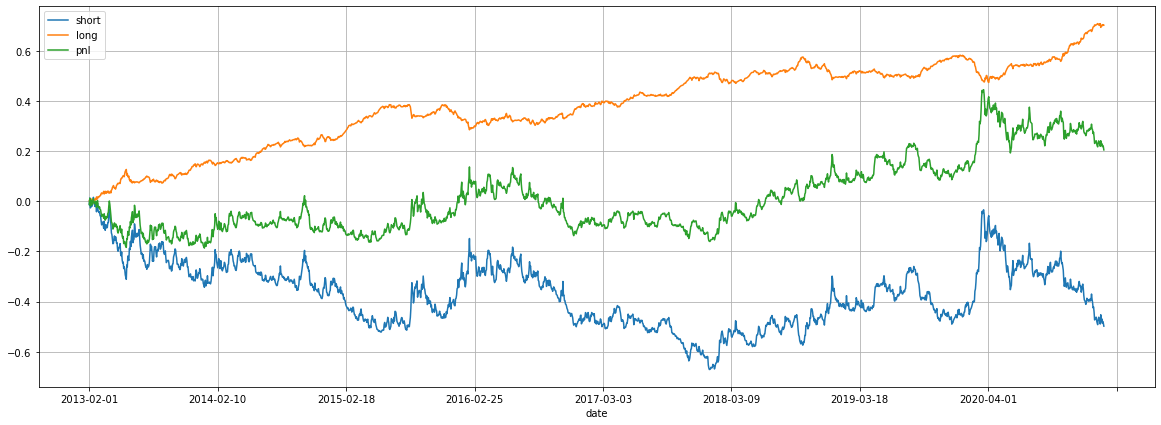

         mean       std        IR
1D  -0.010272  0.250633 -0.040983
5D  -0.005486  0.199754 -0.027465
10D -0.003184  0.188365 -0.016902


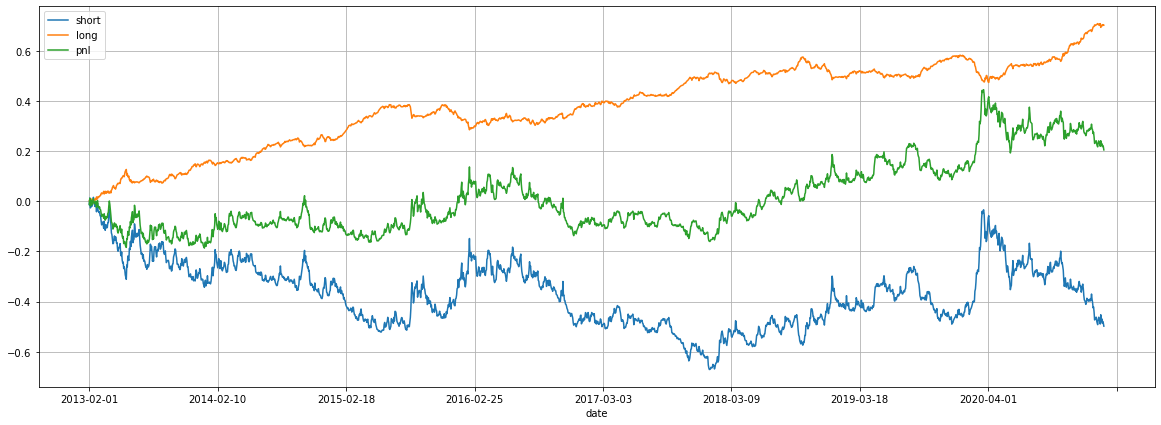

         mean       std        IR
1D  -0.010272  0.250633 -0.040983
5D  -0.005486  0.199754 -0.027465
10D -0.003184  0.188365 -0.016902


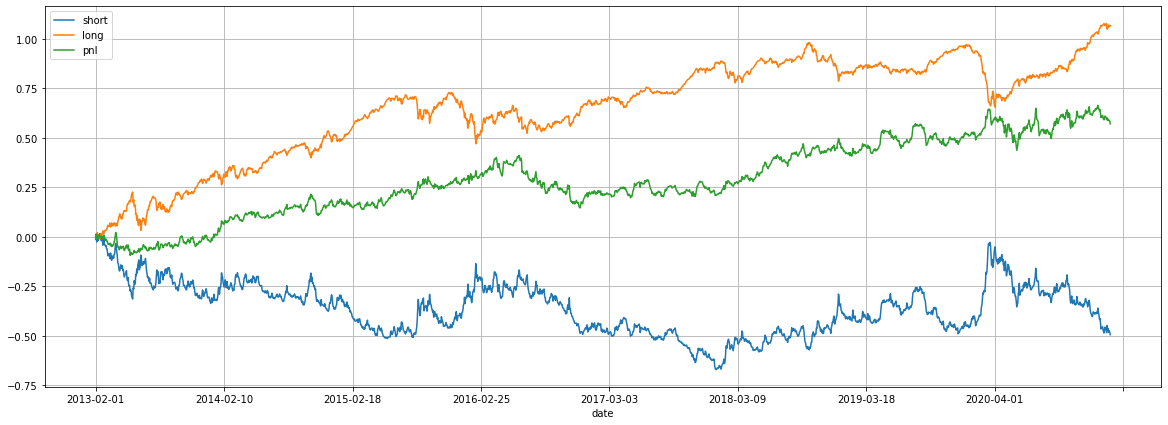

         mean       std        IR
1D  -0.011939  0.223635 -0.053387
5D  -0.012087  0.175789 -0.068759
10D -0.011790  0.164606 -0.071624


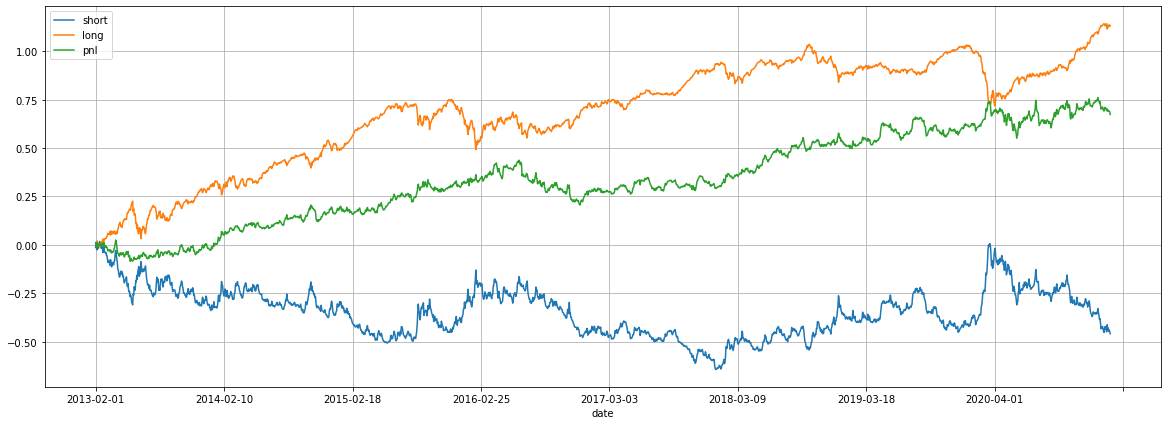

         mean       std        IR
1D  -0.012503  0.210551 -0.059384
5D  -0.012357  0.164203 -0.075257
10D -0.012296  0.153966 -0.079865


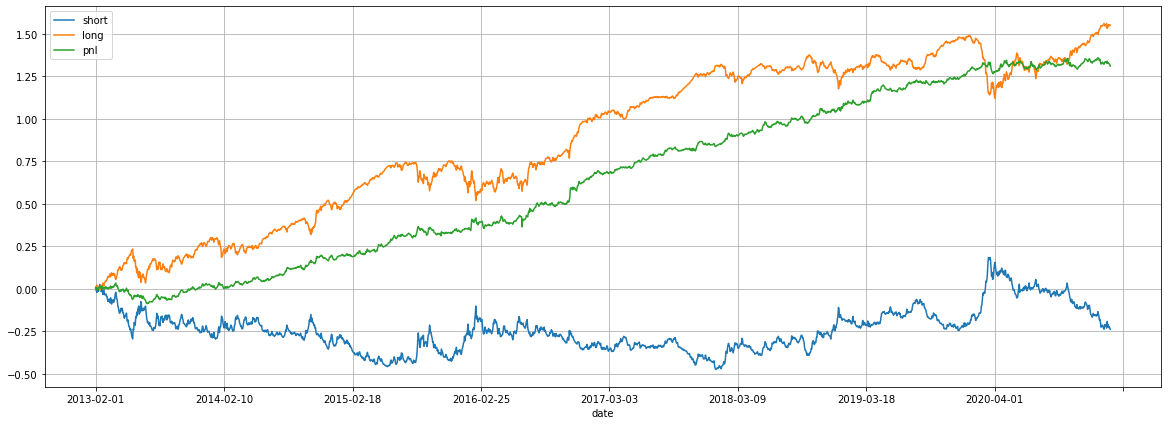

         mean       std        IR
1D  -0.015625  0.162991 -0.095862
5D  -0.017649  0.120070 -0.146990
10D -0.020907  0.111503 -0.187505


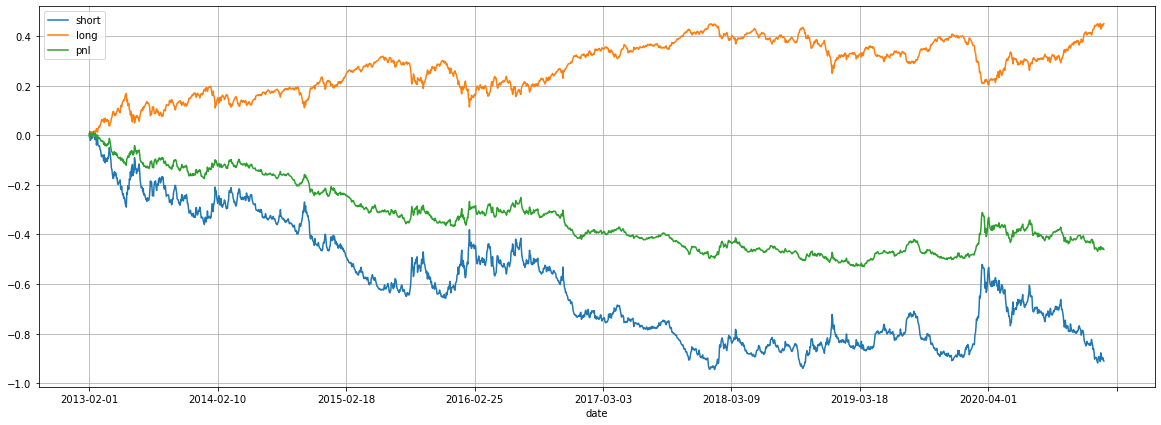

         mean       std        IR
1D   0.007001  0.126171  0.055486
5D   0.013120  0.125637  0.104430
10D  0.014842  0.120544  0.123124


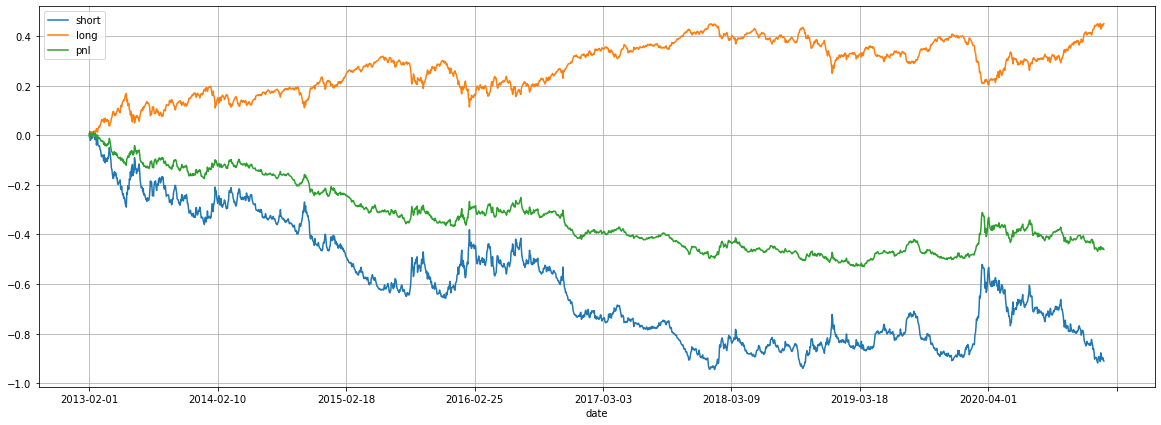

         mean       std        IR
1D   0.007001  0.126171  0.055486
5D   0.013120  0.125637  0.104430
10D  0.014842  0.120544  0.123124


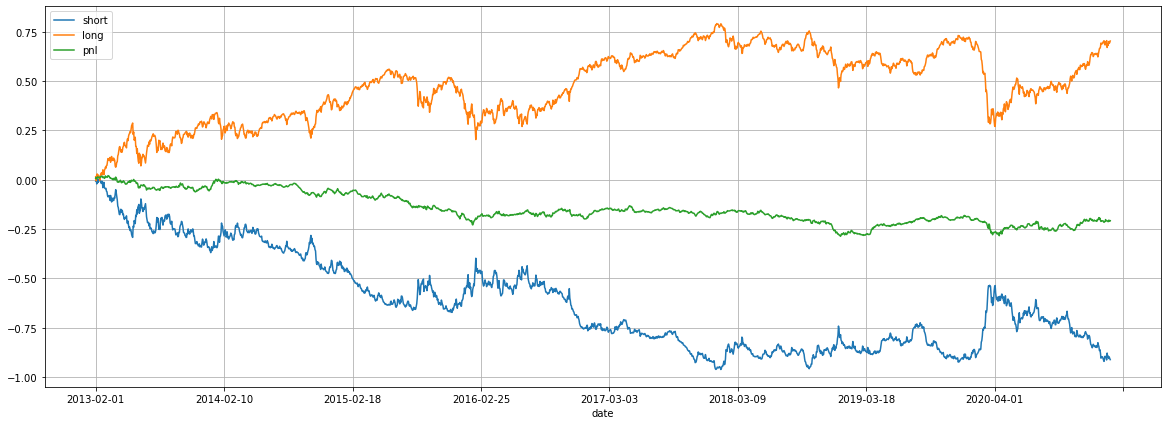

         mean       std        IR
1D   0.006711  0.106556  0.062978
5D   0.008179  0.110201  0.074223
10D  0.007291  0.108300  0.067325


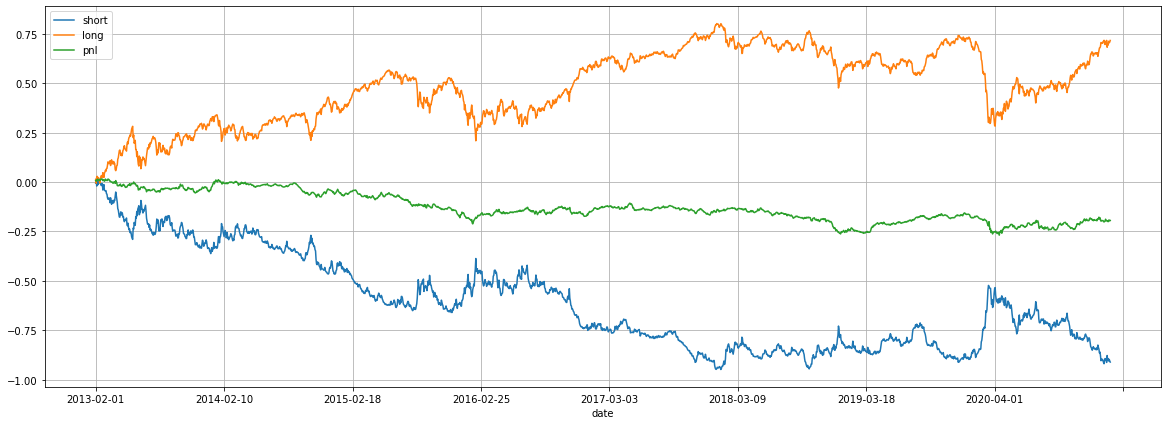

         mean       std        IR
1D   0.006286  0.105621  0.059514
5D   0.007751  0.109006  0.071111
10D  0.007025  0.106946  0.065691


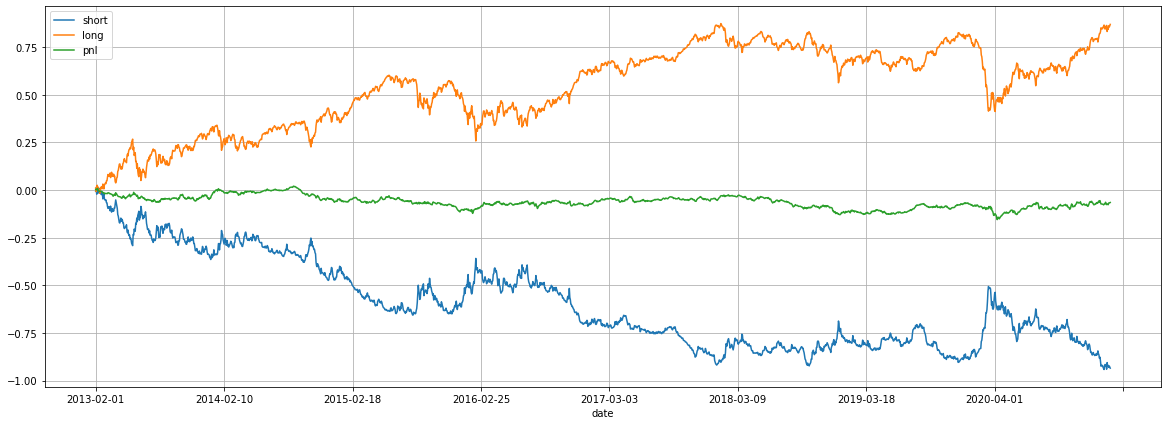

         mean       std        IR
1D   0.004310  0.093999  0.045851
5D   0.004559  0.096212  0.047381
10D  0.005040  0.093145  0.054113


In [396]:
factor_analysis_pipeline(corr1)
factor_analysis_pipeline(corr2)
factor_analysis_pipeline(eig_feat)
factor_analysis_pipeline(deg_feat)
factor_analysis_pipeline(bet_feat)
factor_analysis_pipeline(vol_corr1)
factor_analysis_pipeline(vol_corr2)
factor_analysis_pipeline(vol_eig_feat)
factor_analysis_pipeline(vol_deg_feat)
factor_analysis_pipeline(vol_bet_feat)

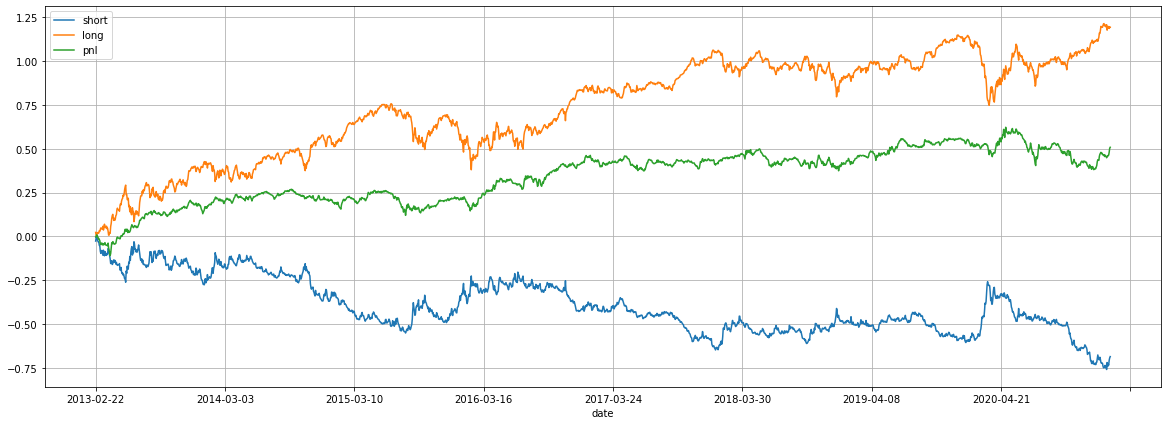

         mean       std        IR
1D  -0.002888  0.165720 -0.017427
5D  -0.009454  0.163230 -0.057920
10D -0.015460  0.161251 -0.095878


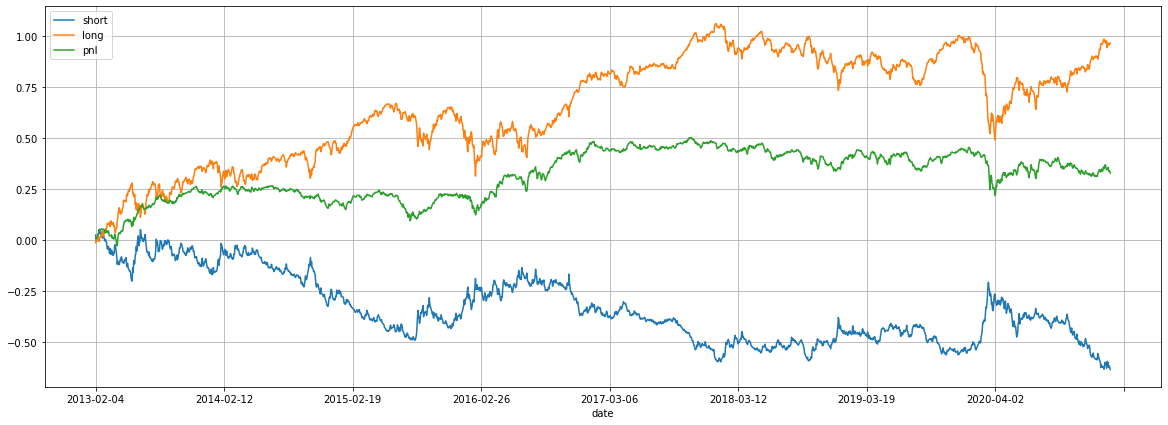

         mean       std        IR
1D  -0.003035  0.182557 -0.016623
5D  -0.005750  0.180695 -0.031820
10D -0.012282  0.176656 -0.069527


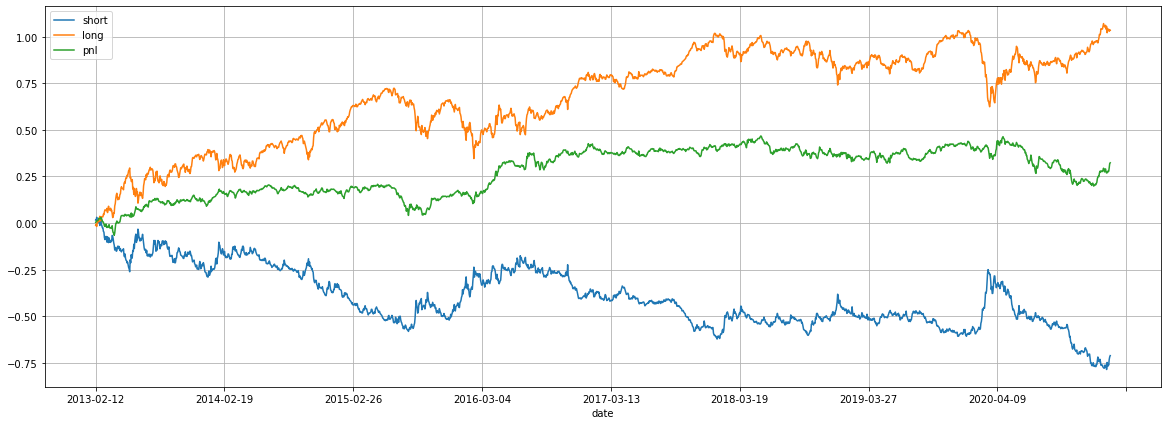

         mean       std        IR
1D  -0.002970  0.155721 -0.019074
5D  -0.007089  0.156476 -0.045304
10D -0.012314  0.156378 -0.078745


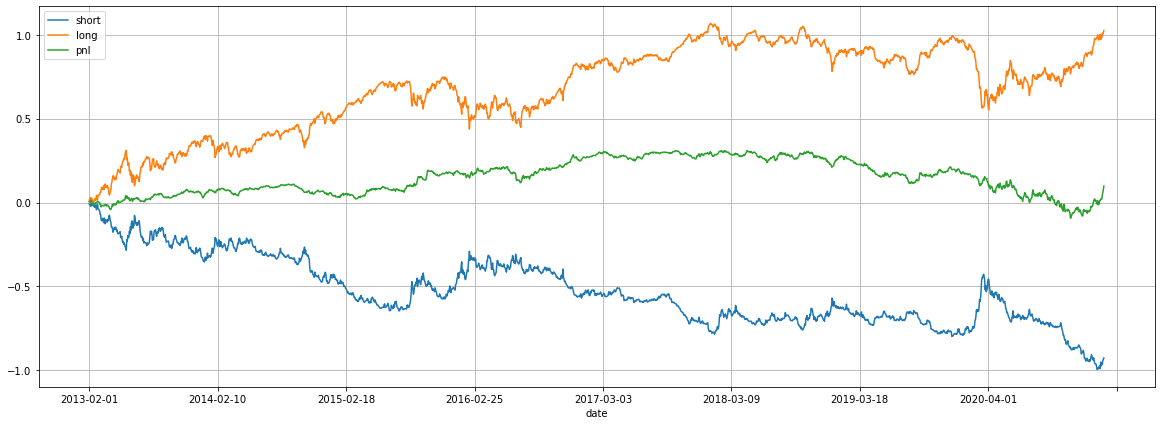

         mean       std        IR
1D   0.001434  0.134561  0.010659
5D  -0.002988  0.136729 -0.021857
10D -0.007974  0.138835 -0.057437


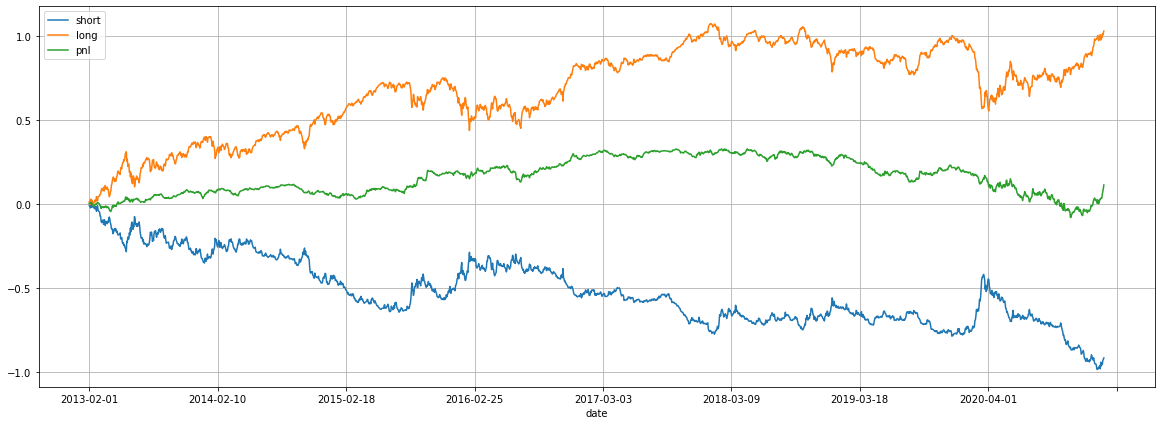

         mean       std        IR
1D   0.001268  0.135623  0.009347
5D  -0.003308  0.137703 -0.024019
10D -0.008608  0.139937 -0.061514


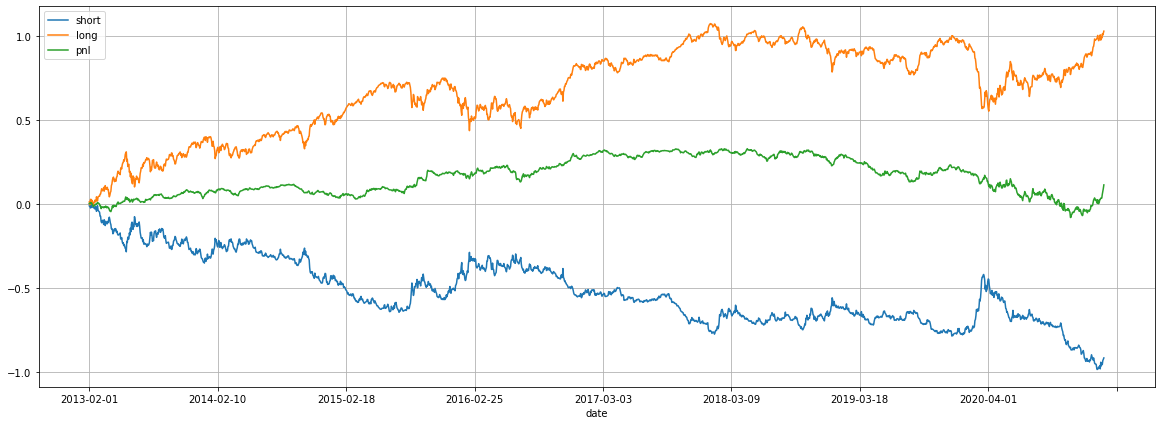

         mean       std        IR
1D   0.001246  0.135772  0.009176
5D  -0.003344  0.137828 -0.024259
10D -0.008675  0.140054 -0.061942


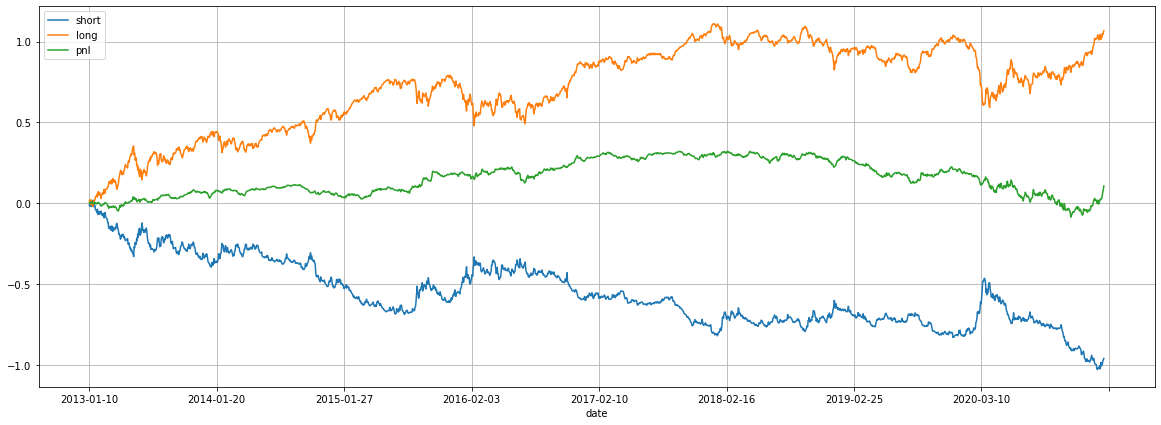

         mean       std        IR
1D   0.001446  0.135045  0.010711
5D  -0.003047  0.137247 -0.022203
10D -0.008321  0.139407 -0.059688


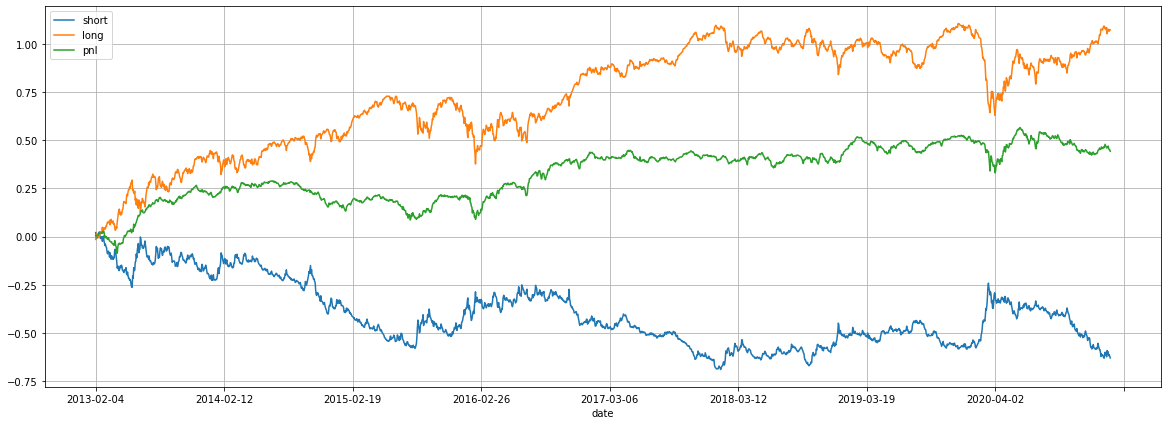

         mean       std        IR
1D  -0.002508  0.177844 -0.014100
5D  -0.003629  0.180146 -0.020142
10D -0.010346  0.175606 -0.058916


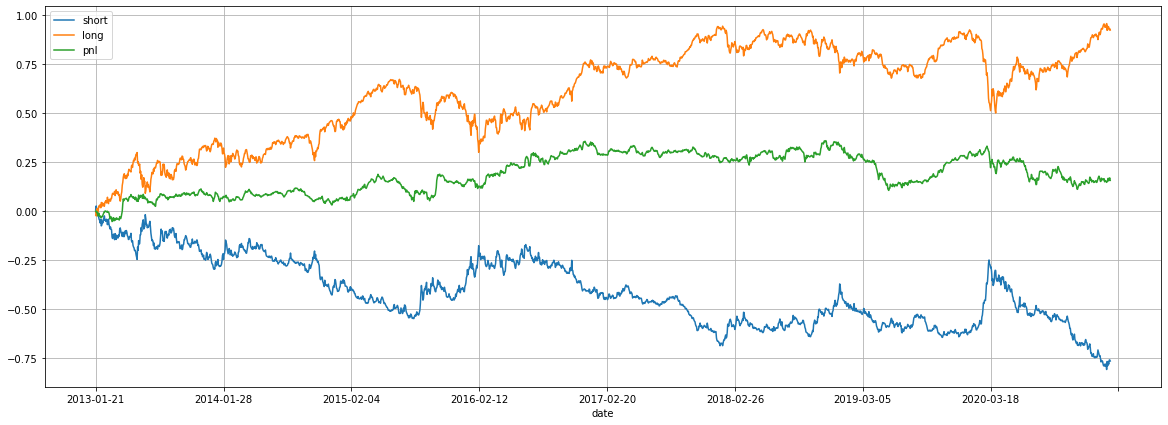

         mean       std        IR
1D  -0.000077  0.144100 -0.000536
5D  -0.004013  0.144910 -0.027693
10D -0.005807  0.138698 -0.041869


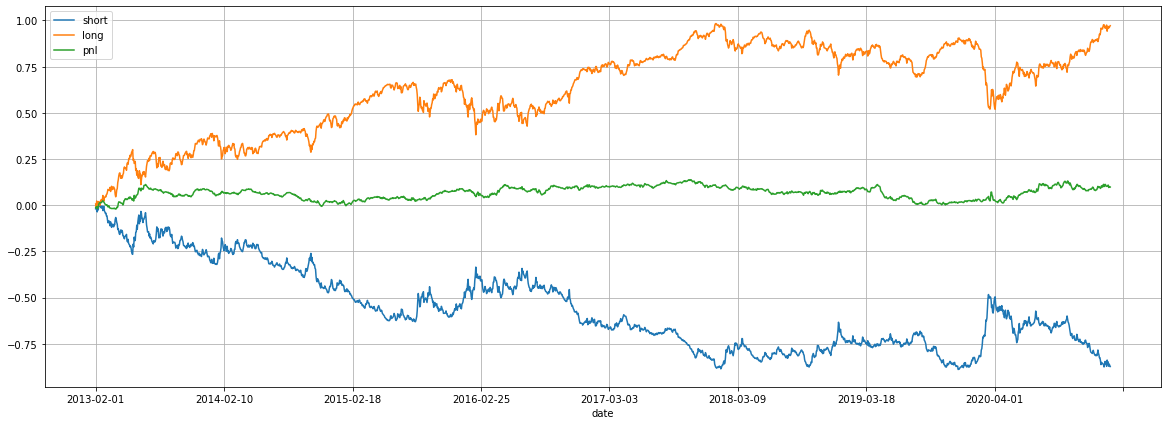

         mean       std        IR
1D  -0.004565  0.108276 -0.042157
5D  -0.002026  0.110431 -0.018349
10D -0.001757  0.106231 -0.016542


In [392]:
factor_analysis_pipeline(macd)
factor_analysis_pipeline(roc)
factor_analysis_pipeline(apo)
factor_analysis_pipeline(ema)
factor_analysis_pipeline(linear)
factor_analysis_pipeline(tsf)
factor_analysis_pipeline(bband)
factor_analysis_pipeline(cmo)
factor_analysis_pipeline(reg)
factor_analysis_pipeline(vcor)

### The factors are weak efficient, so we can use multi-factor model to construct a relative good strategy

In [447]:
# Due to the difference start date of factors, we choose start date as 2013-03-01
start_date = '2013-03-01'
end_date = '2021-03-17'

In [448]:
rtn = close.pct_change(1).dropna(axis=0, how = 'all')
s = 2004-rtn.count()
new_asset = s[s<500].index.tolist()

In [633]:
feat1 = MultiIndexSeries(corr1[new_asset].loc[start_date:end_date],'feat1')
# feat2 = MultiIndexSeries(corr2[new_asset].loc[start_date:end_date],'feat2')
feat3 = MultiIndexSeries(eig_feat[new_asset].loc[start_date:end_date],'feat3')
feat4 = MultiIndexSeries(deg_feat[new_asset].loc[start_date:end_date],'feat4')
feat5 = MultiIndexSeries(bet_feat[new_asset].loc[start_date:end_date],'feat5')
feat6 = MultiIndexSeries(macd[new_asset].loc[start_date:end_date],'feat6')
feat7 = MultiIndexSeries(roc[new_asset].loc[start_date:end_date],'feat7')
feat8 = MultiIndexSeries(apo[new_asset].loc[start_date:end_date],'feat8')
feat9 = MultiIndexSeries(ema[new_asset].loc[start_date:end_date],'feat9')
feat10 = MultiIndexSeries(linear[new_asset].loc[start_date:end_date],'feat10')
feat11 = MultiIndexSeries(tsf[new_asset].loc[start_date:end_date],'feat11')
feat12 = MultiIndexSeries(bband[new_asset].loc[start_date:end_date],'feat12')
feat13 = MultiIndexSeries(cmo[new_asset].loc[start_date:end_date],'feat13')
feat14 = MultiIndexSeries(reg[new_asset].loc[start_date:end_date],'feat14')
feat15 = MultiIndexSeries(vcor[new_asset].loc[start_date:end_date],'feat15')
feat16 = MultiIndexSeries(vol_corr1[new_asset].loc[start_date:end_date],'feat16')
# feat17 = MultiIndexSeries(vol_corr2[new_asset].loc[start_date:end_date],'feat17')
feat18 = MultiIndexSeries(vol_eig_feat[new_asset].loc[start_date:end_date],'feat18')
feat19 = MultiIndexSeries(vol_deg_feat[new_asset].loc[start_date:end_date],'feat19')
feat20 = MultiIndexSeries(vol_bet_feat[new_asset].loc[start_date:end_date],'feat20')
feat_concat = pd.concat([feat1,feat3,feat4,feat5,feat6,
                         feat7,feat8,feat9,feat10,feat11,feat12,feat13,
                         feat14,feat15,feat16,feat18,feat19,feat20],axis=1)

## Strategy

Used the first 1000 days data to train a LSTM network and the rest data is used to test the strategy

In [634]:
data_ = feat_concat.fillna(0).values.reshape(len(new_date),-1,18)
label = rtn[new_asset].shift(-1).loc[new_date].fillna(0).values.reshape(-1,len(new_asset),1)

In [746]:
import torch.nn as nn
import torch
class LSNet(nn.Module):
    def __init__(self,input_size):
        super(LSNet,self).__init__()
        self.rnn = nn.LSTM(input_size = input_size,hidden_size = 80,num_layers = 2,batch_first = False)
        self.fc1 = nn.Linear(80,40)
        self.relu = nn.ReLU()
        self.out = nn.Linear(40,1)
        self.sgm = nn.Sigmoid()
    def forward(self,x):
        r_out,(h_n,h_c) = self.rnn(x,None)
        x = self.relu(self.fc1(r_out))
        out = self.sgm(self.out(x))
        return out
from torch.utils import data
class TestDataset(data.Dataset):
    def __init__(self,data,target):
        self.Data = data
        self.Target = target
    def __getitem__(self,index):
        d = self.Data[index]
        t = torch.tensor(self.Target[index])
        return d,t
    def __len__(self):
        return len(self.Data)


In [751]:
torch.cuda.empty_cache()
net = LSNet(18)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [752]:
import torch
import torch.optim as optim
ts_data = torch.from_numpy(data_[:1000,:,:])
ts_data = ts_data.to(torch.float32)
ts_tart = torch.from_numpy(label[:1000,:,:])
dataset = TestDataset(ts_data,ts_tart)
dataload = data.DataLoader(dataset,batch_size = 200,shuffle = False,num_workers = 0)

mseloss = nn.MSELoss()
lr = 0.01
epoch = 1000
optimizer = optim.SGD(net.parameters(),lr = lr,momentum = 0.9)
l = []
for i in tqdm(range(epoch)):
    running_loss = 0.0
    for train_data,target in dataload:
        train_data,target = train_data.to(device),target.to(device)
        train_data = train_data.to(torch.float32)
        target = target.to(torch.float32)
        net = net.cuda()
        optimizer.zero_grad()
        output = net(train_data)
        loss = mseloss(output,target)
        loss.backward()
        optimizer.step()
        running_loss += loss
    l.append(running_loss.item())

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\QR_Zh\AppData\Local\Temp\ipykernel_44516\1036743888.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(self.Target[index])
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:50<00:00,  5.88it/s]


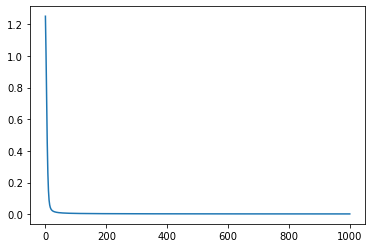

In [753]:
plt.plot(l)

In [757]:
net.to(device)

LSNet(
  (rnn): LSTM(18, 80, num_layers=2)
  (fc1): Linear(in_features=80, out_features=40, bias=True)
  (relu): ReLU()
  (out): Linear(in_features=40, out_features=1, bias=True)
  (sgm): Sigmoid()
)

### The loss function performs a decreasing and convergence trend but the training process only have a small effect on it

In [764]:
torch.cuda.empty_cache()
test_data = torch.from_numpy(data_[1000:,:,:])
test_data = test_data.to(torch.float32)
test_data = test_data

In [784]:
pred1 = net(test_data[:100,:,:])

In [788]:
pred2 = net(test_data[100:200,:,:])

RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 7328000 bytes.

### So sorry for cannot finish the strategy cause I didn't have enough memory and time to restart the kernel. Since I didn't have much experience about strategy as well as built a backtest framework(I used the quant platform before), I can only try my best to do well in factor part...